# Used Cars Dataset 

## Phase 0: Imports and Reading Data

In [64]:
import sklearn as skl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Set the number of columns to 14
pd.set_option('display.max_columns', 14)

In [69]:
cars = pd.read_csv('used_cars.csv')

# Set the target column to be the last one
cars = cars.reindex(columns = [col for col in cars.columns if col != 'Price'] + ['Price'])

## Phase 1: Simple Data Exploration

In [59]:
cars.shape

(44531, 280)

In [60]:
cars.columns

Index(['Model Year', 'Kilometers', 'Engine Capacity', 'Price',
       'Company Name_Adam', 'Company Name_Audi', 'Company Name_BMW',
       'Company Name_Chery', 'Company Name_Chevrolet', 'Company Name_DFSK',
       ...
       'Transmission Type_Automatic', 'Transmission Type_Manual',
       'Registration Status_Registered', 'Registration Status_Un-Registered',
       'Mapped_colors_Bright', 'Mapped_colors_Cool', 'Mapped_colors_Dark',
       'Mapped_colors_Warm', 'Mapped_locations_India',
       'Mapped_locations_Pakistan'],
      dtype='object', length=280)

In [61]:
cars.head()

,Model Year,Kilometers,Engine Capacity,Price,Company Name_Adam,Company Name_Audi,Company Name_BMW,...,Registration Status_Un-Registered,Mapped_colors_Bright,Mapped_colors_Cool,Mapped_colors_Dark,Mapped_colors_Warm,Mapped_locations_India,Mapped_locations_Pakistan
0,2017,15882,1000,2385000,0,0,0,...,1,0,0,1,0,0,1
1,2019,17881,1300,111000,0,0,0,...,0,1,0,0,0,0,1
2,2019,28163,660,1530000,0,0,0,...,1,1,0,0,0,0,1
3,2019,15449,660,1650000,0,0,0,...,0,1,0,0,0,1,0
4,2010,193121,1300,1435000,0,0,0,...,0,0,0,1,0,0,1


In [62]:
cars.describe()

,Model Year,Kilometers,Engine Capacity,Price,Company Name_Adam,Company Name_Audi,Company Name_BMW,...,Registration Status_Un-Registered,Mapped_colors_Bright,Mapped_colors_Cool,Mapped_colors_Dark,Mapped_colors_Warm,Mapped_locations_India,Mapped_locations_Pakistan
count,44531.000000,4.453100e+04,44531.000000,4.453100e+04,44531.000000,44531.000000,44531.000000,...,44531.000000,44531.000000,44531.000000,44531.000000,44531.000000,44531.000000,44531.000000
mean,2011.050616,1.462184e+05,1313.164223,2.005268e+06,0.000022,0.004559,0.003009,...,0.070625,0.394961,0.074937,0.428241,0.099953,0.544654,0.455346
std,6.405624,1.024944e+05,613.329759,2.903053e+06,0.004739,0.067364,0.054774,...,0.256200,0.488848,0.263292,0.494829,0.299940,0.498008,0.498008
min,1990.000000,1.000000e+00,16.000000,1.110000e+05,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2007.000000,7.724800e+04,1000.000000,8.450000e+05,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2013.000000,1.287470e+05,1300.000000,1.450000e+06,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,2016.000000,1.931210e+05,1500.000000,2.300000e+06,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,2019.000000,1.609342e+06,6600.000000,7.750000e+07,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
cars.duplicated().any()

False

In [70]:
cars.isna().any()

Id                     False
Company Name           False
Model Name             False
Model Year             False
Location               False
Mileage                False
Engine Type            False
Engine Capacity        False
Color                  False
Assembly               False
Body Type              False
Transmission Type      False
Registration Status    False
Price                  False
dtype: bool

In [9]:
cars.dtypes

Id                      int64
Company Name           object
Model Name             object
Model Year              int64
Location               object
Mileage                 int64
Engine Type            object
Engine Capacity         int64
Color                  object
Assembly               object
Body Type              object
Transmission Type      object
Registration Status    object
Price                   int64
dtype: object

In [71]:
cars['Color'].value_counts()

Color
White        17588
Silver        8006
Black         6026
Grey          5038
Blue          2127
Assembly      1382
Gold          1003
Maroon         924
Red            822
Green          770
Beige          580
Burgundy       307
Brown          269
Turquoise      230
Bronze         211
Pink           194
Navy           120
Unlisted       109
Yellow          98
Purple          90
Indigo          85
Orange          40
Magenta          2
Wine             1
Name: count, dtype: int64

In [72]:
cars['Body Type'].value_counts()

Body Type
Hatchback     21576
Sedan         18984
SUV            2390
Mini Van       1199
Cross Over     1182
Van             691
Name: count, dtype: int64

In [12]:
cars['Engine Type'].value_counts()

Engine Type
Petrol    43590
Hybrid     1439
Diesel      993
Name: count, dtype: int64

In [73]:
cars['Assembly'].value_counts()

Assembly
Local       31210
Imported    14812
Name: count, dtype: int64

In [14]:
cars['Transmission Type'].value_counts()

Transmission Type
Manual       24611
Automatic    21411
Name: count, dtype: int64

In [15]:
cars['Registration Status'].value_counts()

Registration Status
Registered       42693
Un-Registered     3329
Name: count, dtype: int64

## Phase 2: Data Preparation

We know that the 'Id' column is useless and it doesn't have any relevance to the target column 'Price'. Because of this, we can simply remove this column.

In [16]:
cars.drop('Id', inplace=True, axis=1)

**Note**: The column 'Location' is probably useless as well and should be removed.

Another good thing that we could do is to convert the column 'Mileage' to its corresponding values in kilometers.

In [17]:
def convert(m):
    return int(m * 1.609344)

kms = cars['Mileage'].apply(convert)
cars['Mileage'] = kms
cars.rename(columns = {'Mileage':'Kilometers'}, inplace = True)

There are some missing values in the 'Color' column. Because this is a categorical column and only 3.75% of the dataset have missing values we decided to remove the rows with missing values.

In [18]:
cars.drop(cars[cars['Color'] == 'Assembly'].index, inplace = True)
cars.drop(cars[cars['Color'] == 'Unlisted'].index, inplace = True)

For the purpose of better Data Understanding, we are going to proceed to the binning of the colors.

In [19]:
color_map = {'Beige': 'Warm',
             'Black': 'Dark',
             'Blue': 'Cool',
             'Bronze': 'Warm',
             'Brown': 'Warm',
             'Burgundy': 'Warm',
             'Gold': 'Warm',
             'Green': 'Cool',
             'Grey': 'Dark',
             'Indingo': 'Cool',
             'Magenta': 'Warm',
             'Maroon': 'Warm',
             'Navy': 'Cool',
             'Orange': 'Warm',
             'Pink': 'Warm',
             'Purple': 'Cool',
             'Red': 'Warm',
             'Silver': 'Dark',
             'Turquoise': 'Cool',
             'White': 'Bright',
             'Wine': 'Warm',
             'Yellow': 'Warm'}

cars['Mapped_colors'] = cars['Color'].map(color_map)

The column 'Location' represents the location of the cars, basically where they are available for purchase. The values of this column belong to two countries: India and Pakistan.  

In [20]:
location_map = {'Islamabad': 'Pakistan',
                'KPK': 'Pakistan',
                'Punjab': 'India',
                'Sindh': 'Pakistan',
                'Balochistan': 'Pakistan',
                'Kashmir': 'India'}

cars['Mapped_locations'] = cars['Location'].map(location_map)

## Phase 3: Deep Data Exploration 

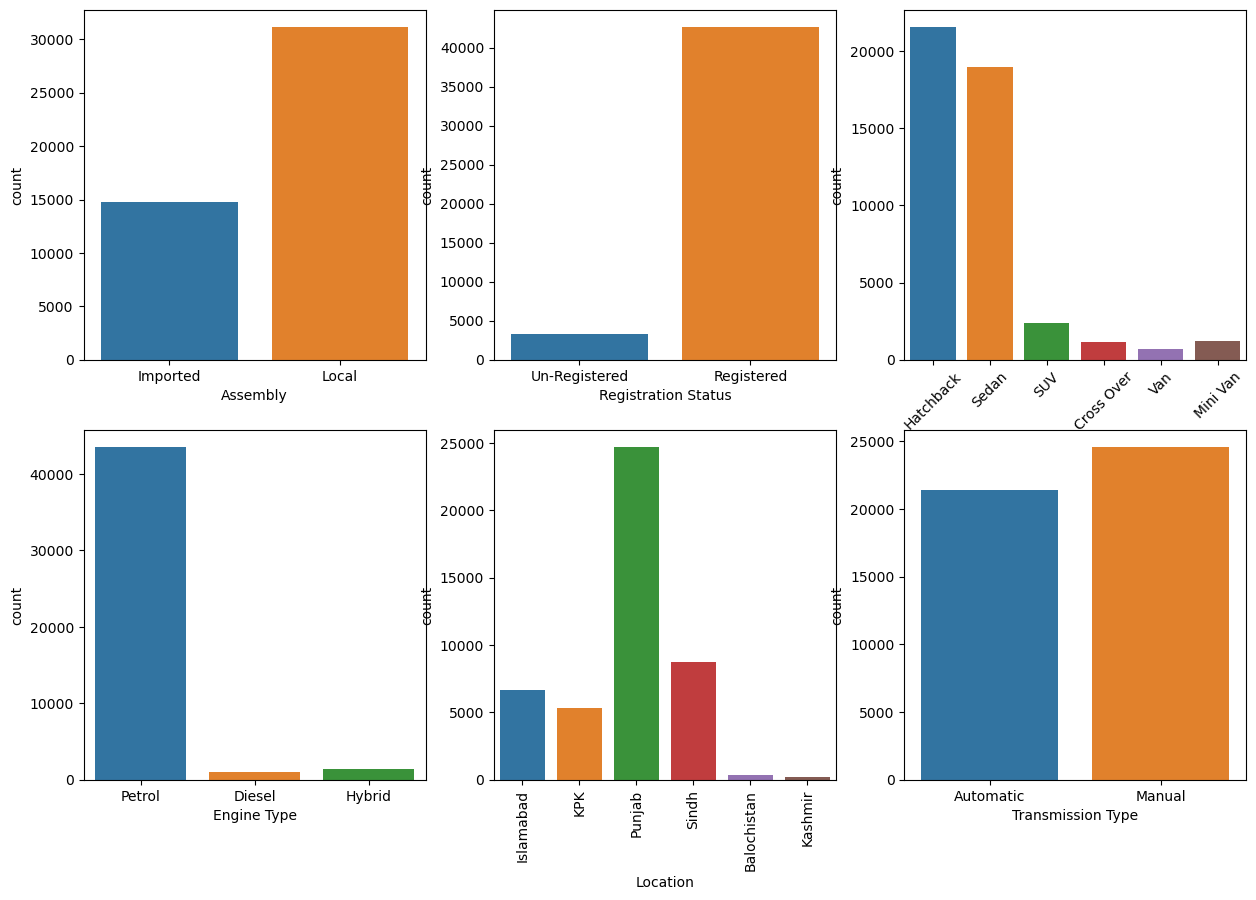

In [75]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
sns.countplot(data=cars, x='Assembly', ax=ax[0, 0])
sns.countplot(data=cars, x='Registration Status', ax=ax[0, 1])
body_tp = sns.countplot(data=cars, x='Body Type', ax=ax[0, 2])
body_tp.tick_params(axis='x', rotation=45)
sns.countplot(data=cars, x='Engine Type', ax=ax[1, 0])
location = sns.countplot(data=cars, x='Location', ax=ax[1, 1])
location.tick_params(axis='x', rotation=90)
sns.countplot(data=cars, x='Transmission Type', ax=ax[1, 2])

plt.show()

Text(0, 0.5, 'Count')

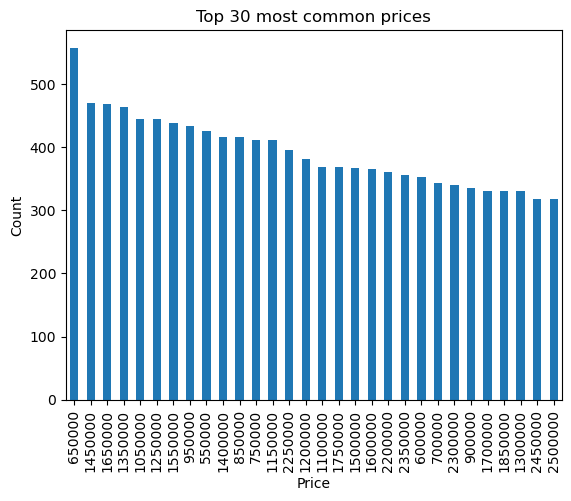

In [21]:
graf = cars['Price'].value_counts().head(30).plot(kind='bar', title="Top 30 most common prices")
graf.set_ylabel('Count')

Text(0.5, 0, 'Price')

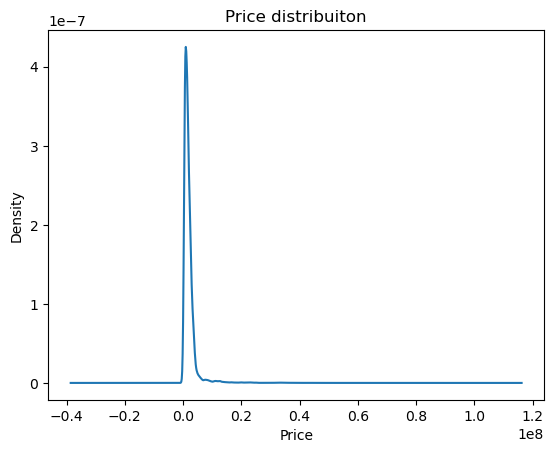

In [22]:
graf = cars['Price'].plot(kind='kde', title='Price distribuiton')
graf.set_xlabel('Price')

#### Relation: 'Company Name' with 'Price'

In [23]:
cars.groupby(by=['Company Name'])['Price'].mean()

Company Name
Adam          2.100000e+05
Audi          8.555778e+06
BMW           5.675694e+06
Chery         5.337500e+05
Chevrolet     6.803947e+05
DFSK          2.029444e+06
Daewoo        3.169565e+05
Daihatsu      1.165193e+06
FAW           1.023500e+06
Fiat          3.550000e+05
Honda         2.142730e+06
Hummer        1.500000e+07
Hyundai       6.226275e+05
Jaguar        1.400000e+07
Jeep          4.516667e+06
KIA           2.082308e+06
Land          3.213889e+06
Lexus         1.369262e+07
MINI          3.570000e+06
Mazda         1.351019e+06
Mercedes      5.191007e+06
Mitsubishi    1.258449e+06
Nissan        1.609835e+06
Porsche       1.875000e+07
Range         1.395438e+07
SsangYong     1.637917e+06
Subaru        1.262288e+06
Suzuki        9.031436e+05
Toyota        2.985915e+06
United        8.597031e+05
Volvo         1.275000e+06
Name: Price, dtype: float64

#### Relation: 'Company Name' and 'Model Name' with 'Price'

In [24]:
cars.groupby(by=['Company Name', 'Model Name'])['Price'].mean()

Company Name  Model Name
Adam          Revo          2.100000e+05
Audi          A3            5.861667e+06
              A4            6.702318e+06
              A5            1.118810e+07
              A6            1.137738e+07
                                ...     
Toyota        Voxy          4.018182e+06
              Wish          2.110769e+06
              iQ            1.446667e+06
United        Bravo         8.597031e+05
Volvo         S40           1.275000e+06
Name: Price, Length: 197, dtype: float64

#### Relation: 'Color' with 'Price'

In [25]:
cars.groupby(by=['Color'])['Price'].mean()

Color
Beige        1.443181e+06
Black        2.978100e+06
Blue         1.356260e+06
Bronze       2.168867e+06
Brown        2.238717e+06
Burgundy     2.181375e+06
Gold         1.203126e+06
Green        1.280708e+06
Grey         1.449484e+06
Indigo       1.715553e+06
Magenta      1.400000e+06
Maroon       1.439175e+06
Navy         1.920408e+06
Orange       2.006875e+06
Pink         1.331665e+06
Purple       2.003667e+06
Red          1.569943e+06
Silver       1.721924e+06
Turquoise    1.346222e+06
White        2.197988e+06
Wine         1.190000e+06
Yellow       1.334398e+06
Name: Price, dtype: float64

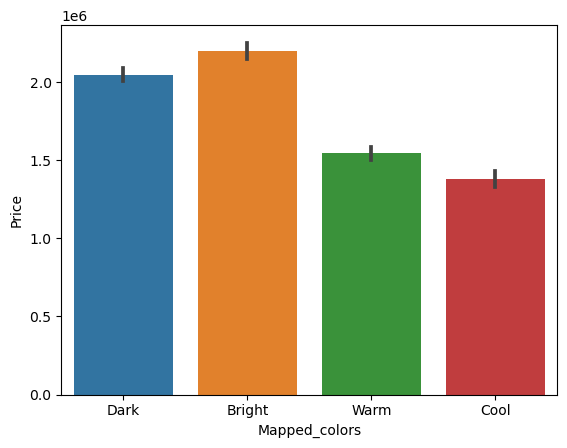

In [26]:
sns.barplot(x='Mapped_colors', y='Price', data=cars)
plt.show()

#### Relation: 'Assembly' with 'Price'

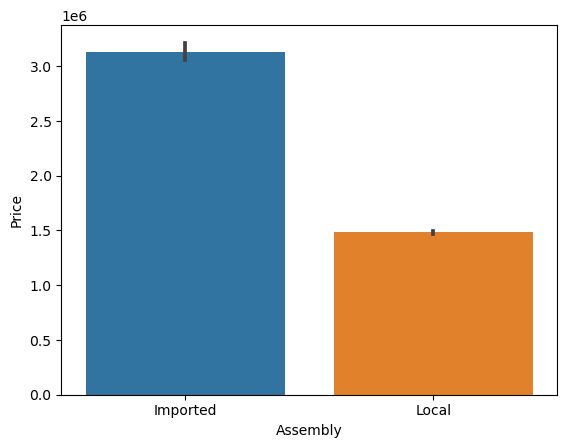

In [27]:
sns.barplot(x='Assembly', y='Price', data=cars)
plt.show()

#### Relation: 'Registration Status' with 'Price'

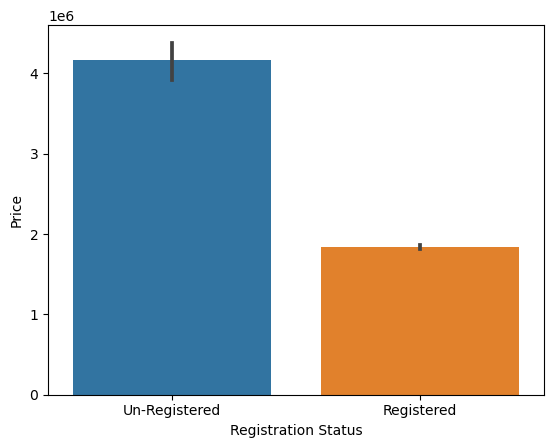

In [28]:
sns.barplot(x='Registration Status', y='Price', data=cars)
plt.show()

#### Relation: 'Body Type' with 'Price'

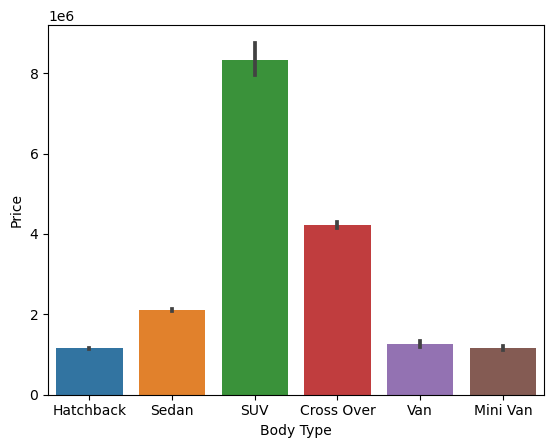

In [29]:
sns.barplot(x='Body Type', y='Price', data=cars)
plt.show()

#### Relation: 'Location' with 'Price'

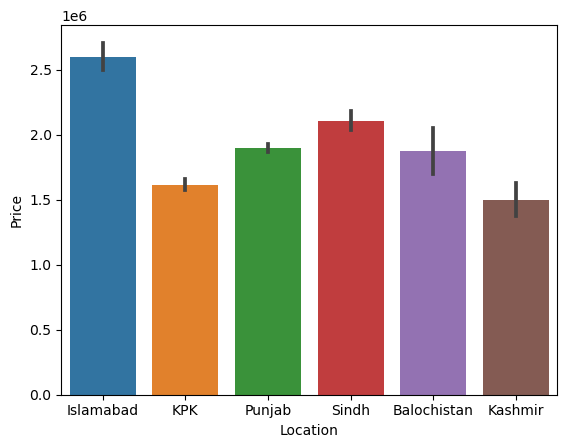

In [30]:
sns.barplot(x='Location', y='Price', data=cars)
plt.show()

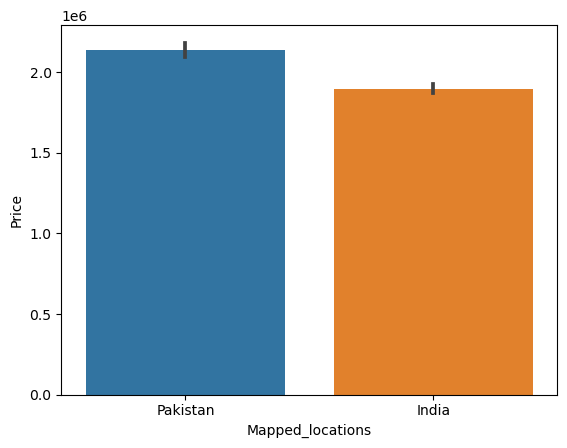

In [31]:
sns.barplot(x='Mapped_locations', y='Price', data=cars)
plt.show()

#### Relation: 'Transmission Type' with 'Price'

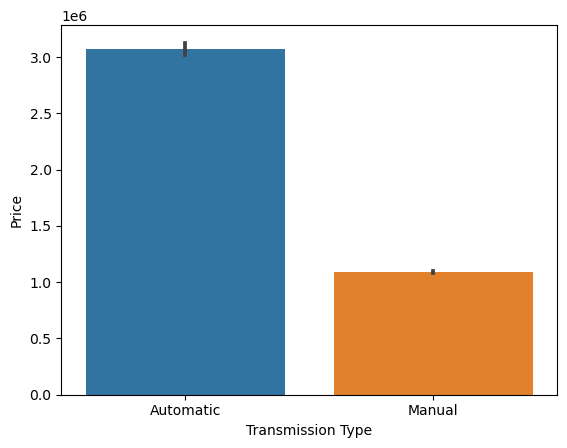

In [32]:
sns.barplot(x='Transmission Type', y='Price', data=cars)
plt.show()

#### Relation: 'Engine Type' with 'Price'

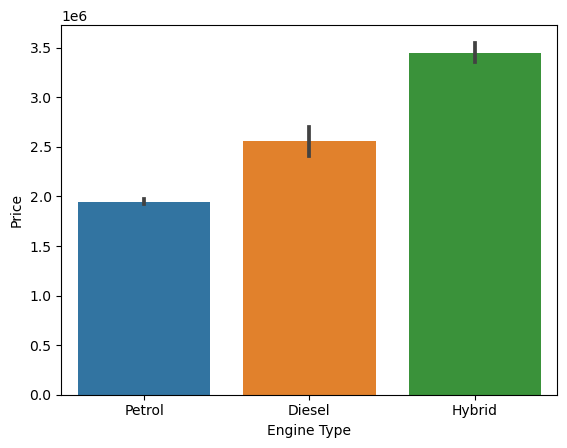

In [33]:
sns.barplot(x='Engine Type', y='Price', data=cars)
plt.show()

#### Relation: 'Engine Capacity' with 'Price'

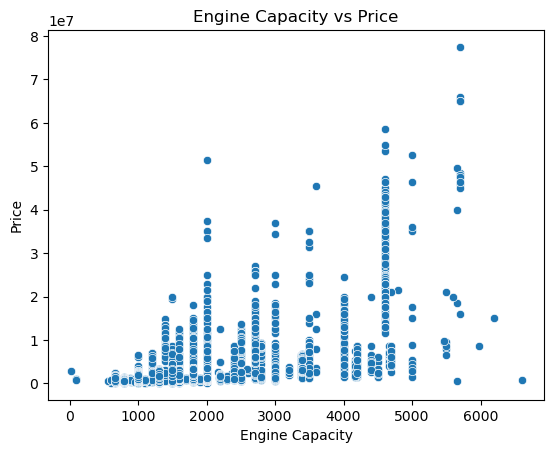

In [34]:
graf = sns.scatterplot(x='Engine Capacity', y='Price', data=cars)
graf.set_title('Engine Capacity vs Price')
plt.show()

#### Relation: 'Engine Capacity' and 'Engine Type' with 'Price'

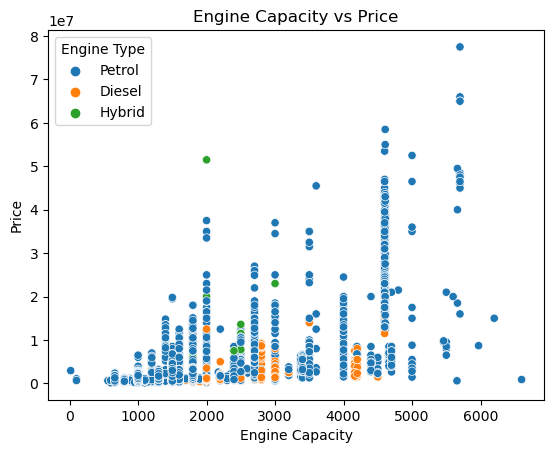

In [35]:
graf = sns.scatterplot(x='Engine Capacity', y='Price', hue='Engine Type', data=cars)
graf.set_title('Engine Capacity vs Price')
plt.show()

#### Relation: 'Kilometers' with 'Price'

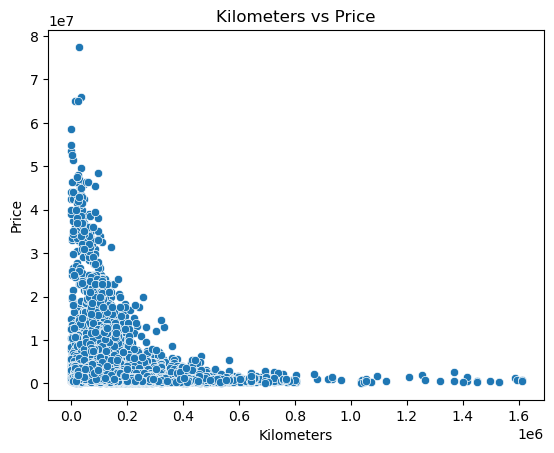

In [36]:
graf = sns.scatterplot(x='Kilometers', y='Price', data=cars)
graf.set_title('Kilometers vs Price')
plt.show()

#### Relation: 'Model Year' with 'Price'

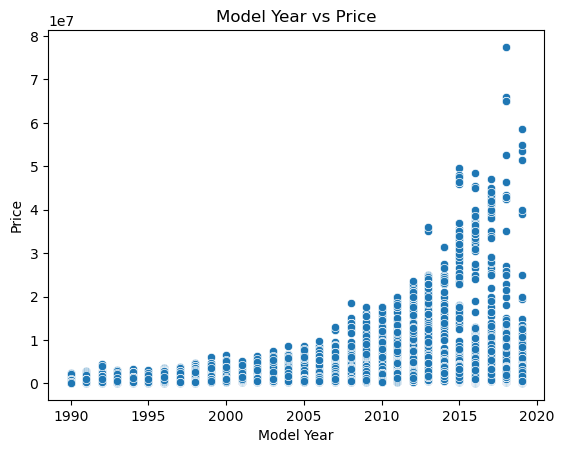

In [37]:
graf = sns.scatterplot(x='Model Year', y='Price', data=cars)
graf.set_title('Model Year vs Price')
plt.show()

#### Correlation Matrix

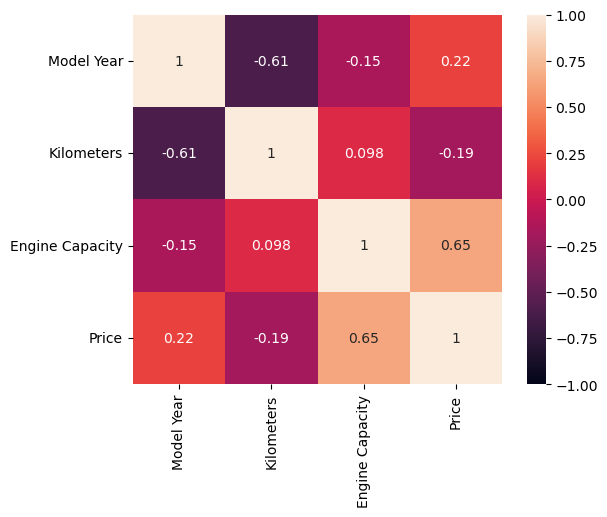

In [38]:
corr_matrix = cars.corr(numeric_only=True)
sns.heatmap(corr_matrix, vmin=-1, vmax=1, square=True, annot=True)
plt.show()

## Phase 4: Model training and evaluation

In [39]:
cars.head()
cars.columns

Index(['Company Name', 'Model Name', 'Model Year', 'Location', 'Kilometers',
       'Engine Type', 'Engine Capacity', 'Color', 'Assembly', 'Body Type',
       'Transmission Type', 'Registration Status', 'Price', 'Mapped_colors',
       'Mapped_locations'],
      dtype='object')

It can be a good ideia to first proceed with data encoding in the categorical data.

In [40]:
columns_to_encode = ['Company Name', 'Model Name','Location',
                     'Engine Type', 'Color', 'Assembly', 'Body Type','Transmission Type', 
                    'Registration Status','Mapped_colors','Mapped_locations']
cars = pd.get_dummies(cars, columns=columns_to_encode, dtype=int)
cars

,Model Year,Kilometers,Engine Capacity,Price,Company Name_Adam,Company Name_Audi,Company Name_BMW,...,Registration Status_Un-Registered,Mapped_colors_Bright,Mapped_colors_Cool,Mapped_colors_Dark,Mapped_colors_Warm,Mapped_locations_India,Mapped_locations_Pakistan
0,2017,15882,1000,2385000,0,0,0,...,1,0,0,1,0,0,1
1,2019,17881,1300,111000,0,0,0,...,0,1,0,0,0,0,1
2,2019,28163,660,1530000,0,0,0,...,1,1,0,0,0,0,1
3,2019,15449,660,1650000,0,0,0,...,0,1,0,0,0,1,0
4,2010,193121,1300,1435000,0,0,0,...,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46016,2017,64373,1800,3300000,0,0,0,...,0,0,0,1,0,1,0
46017,2015,51499,1500,3400000,0,0,0,...,1,0,0,1,0,1,0
46018,2015,83685,1500,2450000,0,0,0,...,1,0,1,0,0,1,0
46019,2015,201168,1800,3250000,0,0,0,...,0,0,0,1,0,1,0


In [41]:
X = cars.drop('Price', axis=1)
y = cars['Price']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 2023)

In [43]:
#from xgboost import XGBRegressor
#import xgboost as xgb
# Create a list of regression model
models = [
    ## ("Linear Regression", LinearRegression()),
    ("Decision Tree Regression", DecisionTreeRegressor()),
    ("Random Forest Regression", RandomForestRegressor()),
    ("ExtraTrees",ExtraTreesRegressor()),
    ("GradientBoosting",GradientBoostingRegressor())
]
mae_values = []
mse_values = []
rmse_values = []
# Iterate through the models, train, and evaluate them
for model_name, model in models:
    # Train the model
    model.fit(X_train, y_train)
    score = model.score(X_test,y_test)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Print the results
    print(f"Model: {model_name}")
    print(f"Score: {score:.2%}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R2) Score: {r2:.2f}")
    print("-" * 40)


ModuleNotFoundError: No module named 'xgboost'